In [1]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from scipy.sparse import coo_matrix
import pandas as pd
import scipy.sparse as sp
import numpy as np
from tqdm import tqdm

import warnings
warnings.simplefilter('ignore', FutureWarning)

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

import sklearn.metrics as m
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline

from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import bisect
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'xgboost'

In [3]:
def reduce_mem_usage(df):
    
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:    
        
        
        col_type = df[col].dtype.name

        if col_type not in ['object', 'category', 'datetime64[ns]']:
                
                
                
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                    
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df #= reduce_mem_usage(df)

def age_bucket(x):
    return bisect.bisect_left([18,25,35,45,55,65], x, lo=1)


In [4]:
train = reduce_mem_usage(pd.read_csv('E:/mts/train.csv')\
.merge(pd.read_feather('E:/mts/user_emb_host.feather'), how='inner', on='user_id')\
.sort_values(by='user_id'))

train.index = train['user_id'] 
train.drop('user_id', axis=1, inplace=True)

Memory usage of dataframe is 933.15 MB
Memory usage after optimization is: 236.89 MB
Decreased by 74.6%


In [5]:
train_tf_idf = sp.load_npz('E:/mts/tf_idf_train.npz')
train_tf_idf = np.array([train_tf_idf.getrow(i).toarray()[0] for i in range(train_tf_idf.shape[0])])

train_tf_idf_1 = sp.load_npz('E:/mts/tf_idf_train_1.npz')
train_tf_idf_1 = np.array([train_tf_idf_1.getrow(i).toarray()[0] for i in range(train_tf_idf_1.shape[0])])

train_tf_idf_2 = sp.load_npz('E:/mts/tf_idf_train_2.npz')
train_tf_idf_2 = np.array([train_tf_idf_2.getrow(i).toarray()[0] for i in range(train_tf_idf_2.shape[0])])

train_tf_idf_3 = sp.load_npz('E:/mts/tf_idf_train_3.npz')
train_tf_idf_3 = np.array([train_tf_idf_3.getrow(i).toarray()[0] for i in range(train_tf_idf_3.shape[0])])

train_tf_idf_4 = sp.load_npz('E:/mts/tf_idf_train_4.npz')
train_tf_idf_4 = np.array([train_tf_idf_4.getrow(i).toarray()[0] for i in range(train_tf_idf_4.shape[0])])


In [6]:
train_tf_idf_date = sp.load_npz('E:/mts/date_tf_idf_train.npz')
train_tf_idf_date = np.array([train_tf_idf_date.getrow(i).toarray()[0] for i in range(train_tf_idf_date.shape[0])])

In [7]:
train_tf_idf = pd.DataFrame(train_tf_idf)
train_tf_idf.index = train.index

train_tf_idf_1 = pd.DataFrame(train_tf_idf_1)
train_tf_idf_1.index = train.index

train_tf_idf_2 = pd.DataFrame(train_tf_idf_2)
train_tf_idf_2.index = train.index

train_tf_idf_3 = pd.DataFrame(train_tf_idf_3)
train_tf_idf_3.index = train.index

train_tf_idf_4 = pd.DataFrame(train_tf_idf_4)
train_tf_idf_4.index = train.index

train_tf_idf_date = pd.DataFrame(train_tf_idf_date)
train_tf_idf_date.index = train.index

In [8]:
train = pd.concat([train, train_tf_idf, train_tf_idf_1, train_tf_idf_2, train_tf_idf_3, train_tf_idf_4, train_tf_idf_date], axis=1)
del train_tf_idf, train_tf_idf_1, train_tf_idf_2, train_tf_idf_3, train_tf_idf_4, train_tf_idf_date

In [9]:
train.columns = list(map(str, train.columns))
train.columns = [f'{col}_{i}' if train.columns.tolist().count(col) > 1 else col for i, col in enumerate(train.columns)]


In [10]:
train

,age,is_male,days_first_to_last_visit,first_last_0,first_last_1,first_last_2,first_last_3,first_last_4,first_last_5,mean_using_internet,...,0_4175,1_4176,2_4177,3_4178,4_4179,5_4180,6_4181,7_4182,8_4183,9_4184
user_id,,,,,,,,,,,,,,,,,,,,,
0,35.0,0.0,18,0,1,0,0,0,0,3.294922,...,0.386656,0.377462,0.363680,0.346869,0.328177,0.307818,0.286075,0.262906,0.238379,0.212613
1,41.0,0.0,20,0,1,0,0,0,0,3.283203,...,0.371811,0.365659,0.355268,0.342105,0.327265,0.310950,0.293431,0.274661,0.254697,0.233658
2,25.0,0.0,57,0,0,0,1,0,0,3.330078,...,0.307015,0.313171,0.316554,0.318228,0.319079,0.319236,0.318938,0.318102,0.316753,0.315000
3,50.0,1.0,16,0,1,0,0,0,0,3.312500,...,0.406636,0.393187,0.374667,0.352767,0.328700,0.302703,0.275070,0.245770,0.214883,0.182530
4,28.0,0.0,42,0,0,1,0,0,0,3.970703,...,0.365757,0.360819,0.351783,0.340077,0.326778,0.312079,0.296250,0.279238,0.261099,0.241951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415308,49.0,NaN,0,1,0,0,0,0,0,3.316406,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
415309,31.0,0.0,0,1,0,0,0,0,0,3.316406,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
415311,39.0,0.0,0,1,0,0,0,0,0,3.316406,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# SEX

In [11]:
train_sex = train[train['is_male'] != 'NA'].dropna()
train_sex['is_male'] = train_sex['is_male'].astype('int')
X_sex = train_sex.drop(['age', 'is_male'], axis = 1)
y_sex = train_sex['is_male']



In [12]:
x_train, x_val, y_train, y_val = train_test_split(\
    X_sex, y_sex, test_size = 0.2, random_state = 350)

# Фильтранем признаки

In [13]:
%%time

clf_sex = CatBoostClassifier(
    custom_loss=['AUC', 'Accuracy'],
    task_type='GPU', 
    devices='0:1',
    random_seed=350,
)
clf_sex.fit(
    x_train, 
    y_train,
    verbose = False,
    plot=True,
    eval_set=(x_val, y_val),
       )
print(f'GINI по полу {2 * m.roc_auc_score(y_val, clf_sex.predict_proba(x_val)[:,1]) - 1:2.3f}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

GINI по полу 0.702
Wall time: 1min 21s


In [13]:
print(m.classification_report(y_val, clf_sex.predict(x_val)))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76     25779
           1       0.77      0.77      0.77     27074

    accuracy                           0.76     52853
   macro avg       0.76      0.76      0.76     52853
weighted avg       0.76      0.76      0.76     52853



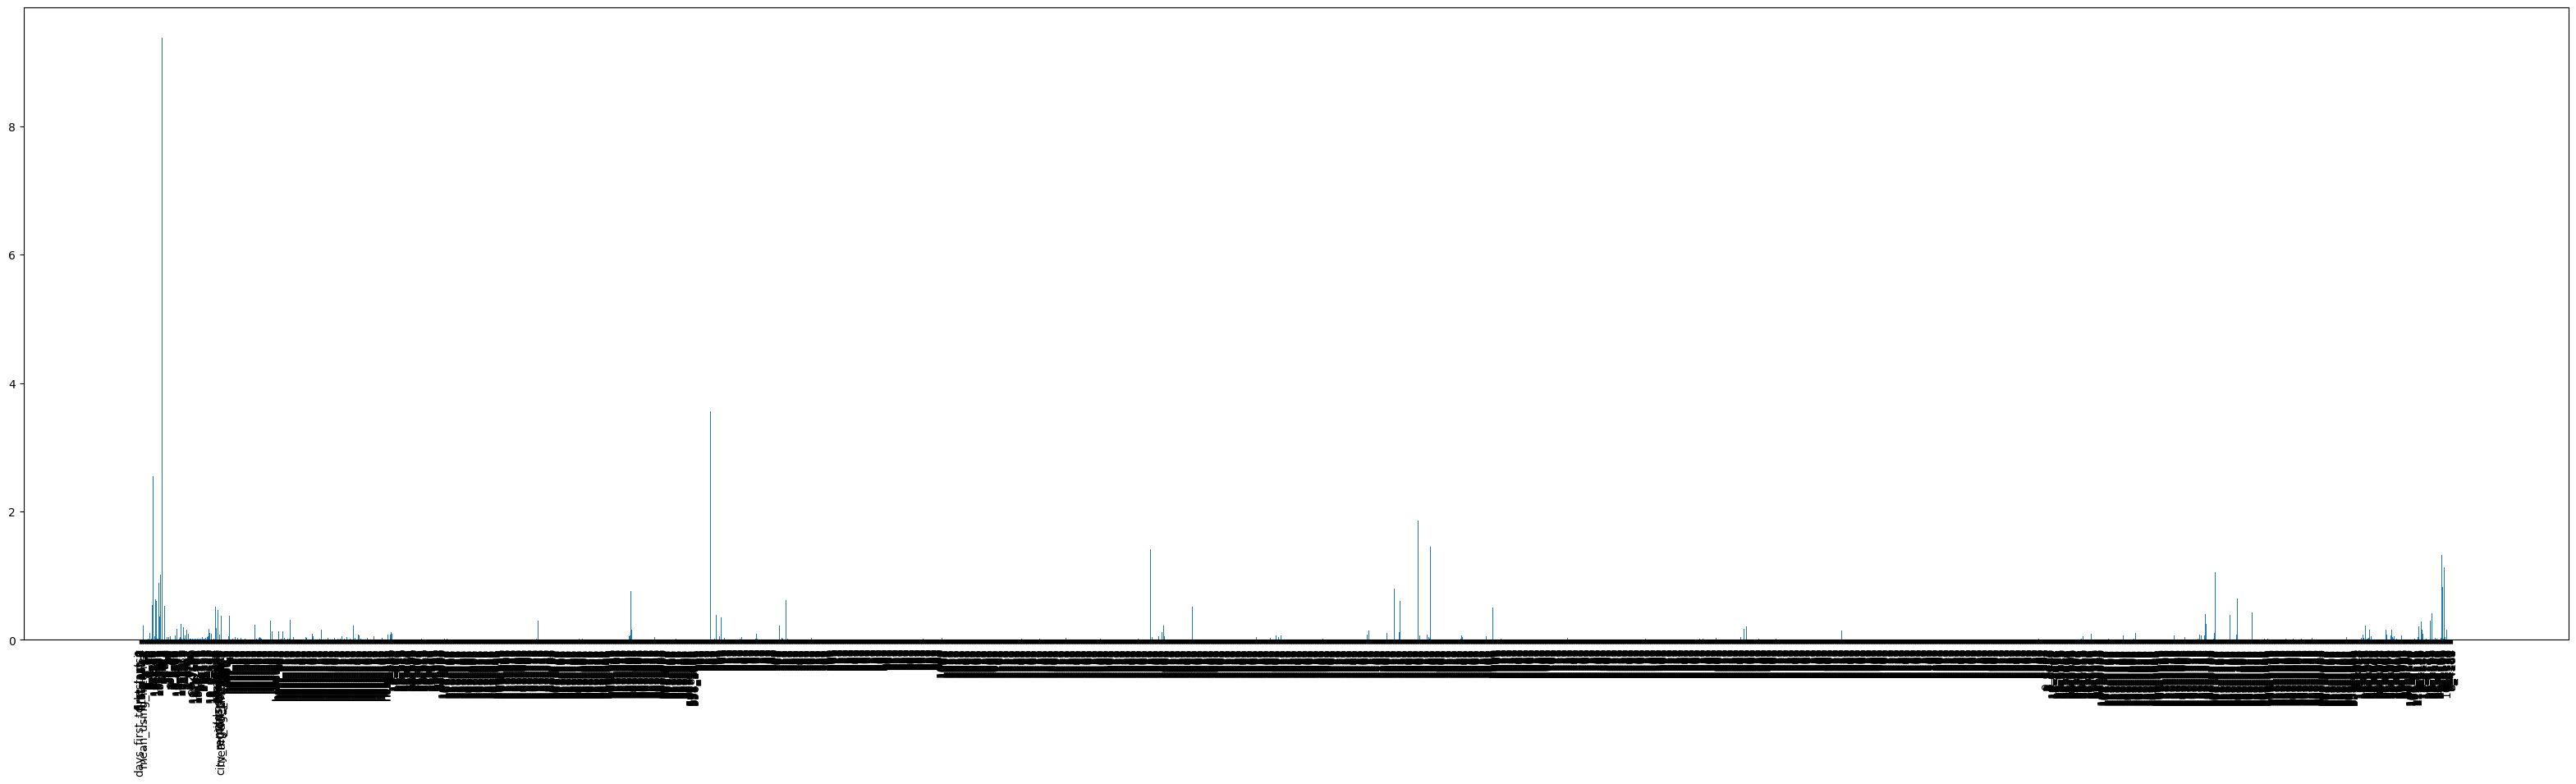

In [14]:
plt.figure(figsize=(40, 10))
plt.bar(train.columns[2:],clf_sex.feature_importances_)
plt.xticks(rotation=90);

In [15]:
print(f'Кол-во беспонтовых фичей: {len(np.where(clf_sex.feature_importances_ == 0)[0])}')

Кол-во беспонтовых фичей: 3352


In [16]:
importance = clf_sex.get_feature_importance(prettified=True)

In [20]:
importance

,Feature Id,Importances
0,23_x,9.380806
1,369_3820,5.188831
2,647,4.117150
3,584,3.560249
4,226_3677,3.055506
...,...,...
4178,5_4180,0.000000
4179,6_4181,0.000000
4180,7_4182,0.000000
4181,8_4183,0.000000


In [17]:
low_importance_features = [row['Feature Id'] for _, row in importance.iterrows() if row['Importances'] == 0]

In [18]:
X_sex = X_sex.drop(low_importance_features, axis=1)

# Проверим модели

In [ ]:
%%time
# Список наименований базовых алгоритмов
names = [
#         'Логистическая регрессия', 
#          'Байесовский классификатор',
         'Случайный лес',
         'Градиентный бустинг XGBoost',
         'Градиентный бустинг CatBoost', 
         'Градиентный бустинг LightGBM'
]
# Список алгоритмов
models = [
#         LogisticRegression(),
#           GaussianNB(), 
          RandomForestClassifier(n_jobs=-1, random_state=42), 
          XGBClassifier(objective='binary:logistic', random_state=42, n_jobs=-1),
          CatBoostClassifier(random_state=42, verbose = False, task_type='GPU', devices='0:1',),
          LGBMClassifier(random_state=42, n_jobs=-1)
]
scores = []
for model in tqdm(models): # кросс-валидация на каждом алгоритме с подсчетом средней метрики
    model.fit(x_train, y_train)
    pred = model.predict(x_val)
#     scores.append(roc_auc_score(y_val, pred))
    scores.append(cross_val_score(model, X_sex, y_sex, cv=4, n_jobs=-1).mean())
    print(scores)
    del model, pred
# Вывод метрик качества рассматриваемых алгоритмов
pd.DataFrame({'score': scores}, index=names).sort_values(by='score', ascending=False)

In [ ]:
# report = pd.DataFrame({'score': scores}, index=names).sort_values(by='score', ascending=False)
# report.to_csv('./report_clf.csv', index_label=False)

In [ ]:
# %%time
# x_train, x_val, y_train, y_val = train_test_split(\
#     X_sex, y_sex, test_size = 0.2, random_state = 350)
# clf_sex = CatBoostClassifier(
#     iterations=1000,
#     task_type='GPU', 
#     devices='0:1',
#     custom_loss=['AUC', 'Accuracy'],
#     max_depth=8,
#     l2_leaf_reg=2
# )
# clf_sex.fit(
#     x_train, 
#     y_train,
# #     cat_features= CAT_SEX_COLS,
#     verbose = False,
#     plot=True,
#     eval_set=(x_val, y_val),
#        )
# print(f'GINI по полу {2 * m.roc_auc_score(y_val, clf_sex.predict_proba(x_val)[:,1]) - 1:2.3f}')

In [ ]:
print(f'GINI по полу {2 * m.roc_auc_score(y_val, clf_sex.predict_proba(x_val)[:,1]) - 1:2.3f}')

In [ ]:
print(m.classification_report(y_val, clf_sex.predict(x_val)))

In [ ]:
plt.figure(figsize=(40, 10))
plt.bar(train.columns[2:],clf_sex.feature_importances_)
plt.xticks(rotation=90);

# AGE

In [21]:
train_age = train[train['age'] != 'NA'].dropna()
train_age['age'] = train_age['age'].map(age_bucket).astype('int')
X_age = train_age.drop(['age', 'is_male'], axis = 1)
y_age = train_age['age']


In [22]:
%%time
x_train, x_val, y_train, y_val = train_test_split(X_age, y_age, test_size = 0.2, random_state = 350)

clf_age = CatBoostClassifier(
    iterations=1500,
    task_type='GPU', 
    devices='0:1',
    custom_loss=['AUC', 'Accuracy'],
    l2_leaf_reg=10,
    boosting_type='Plain',
#     learning_rate=0.001,
#     num_trees=200


)

clf_age.fit(
    x_train, 
    y_train,
    verbose = False,
    plot=True,
    eval_set=(x_val, y_val),
       )


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


CPU times: total: 9min 8s
Wall time: 4min 2s


In [ ]:
# y_age.hist()

In [24]:
predict = clf_age.predict(x_val).reshape(1, -1)[0]
print(m.classification_report(y_val.values, predict, \
                            target_names = ['19-25', '26-35','36-45', '46-55', '56-65', '66+']))

              precision    recall  f1-score   support

       19-25       0.57      0.38      0.46      6348
       26-35       0.51      0.64      0.57     17335
       36-45       0.41      0.54      0.47     15219
       46-55       0.39      0.22      0.28      8255
       56-65       0.44      0.21      0.29      4612
         66+       0.37      0.01      0.02      1084

    accuracy                           0.46     52853
   macro avg       0.45      0.33      0.35     52853
weighted avg       0.46      0.46      0.45     52853



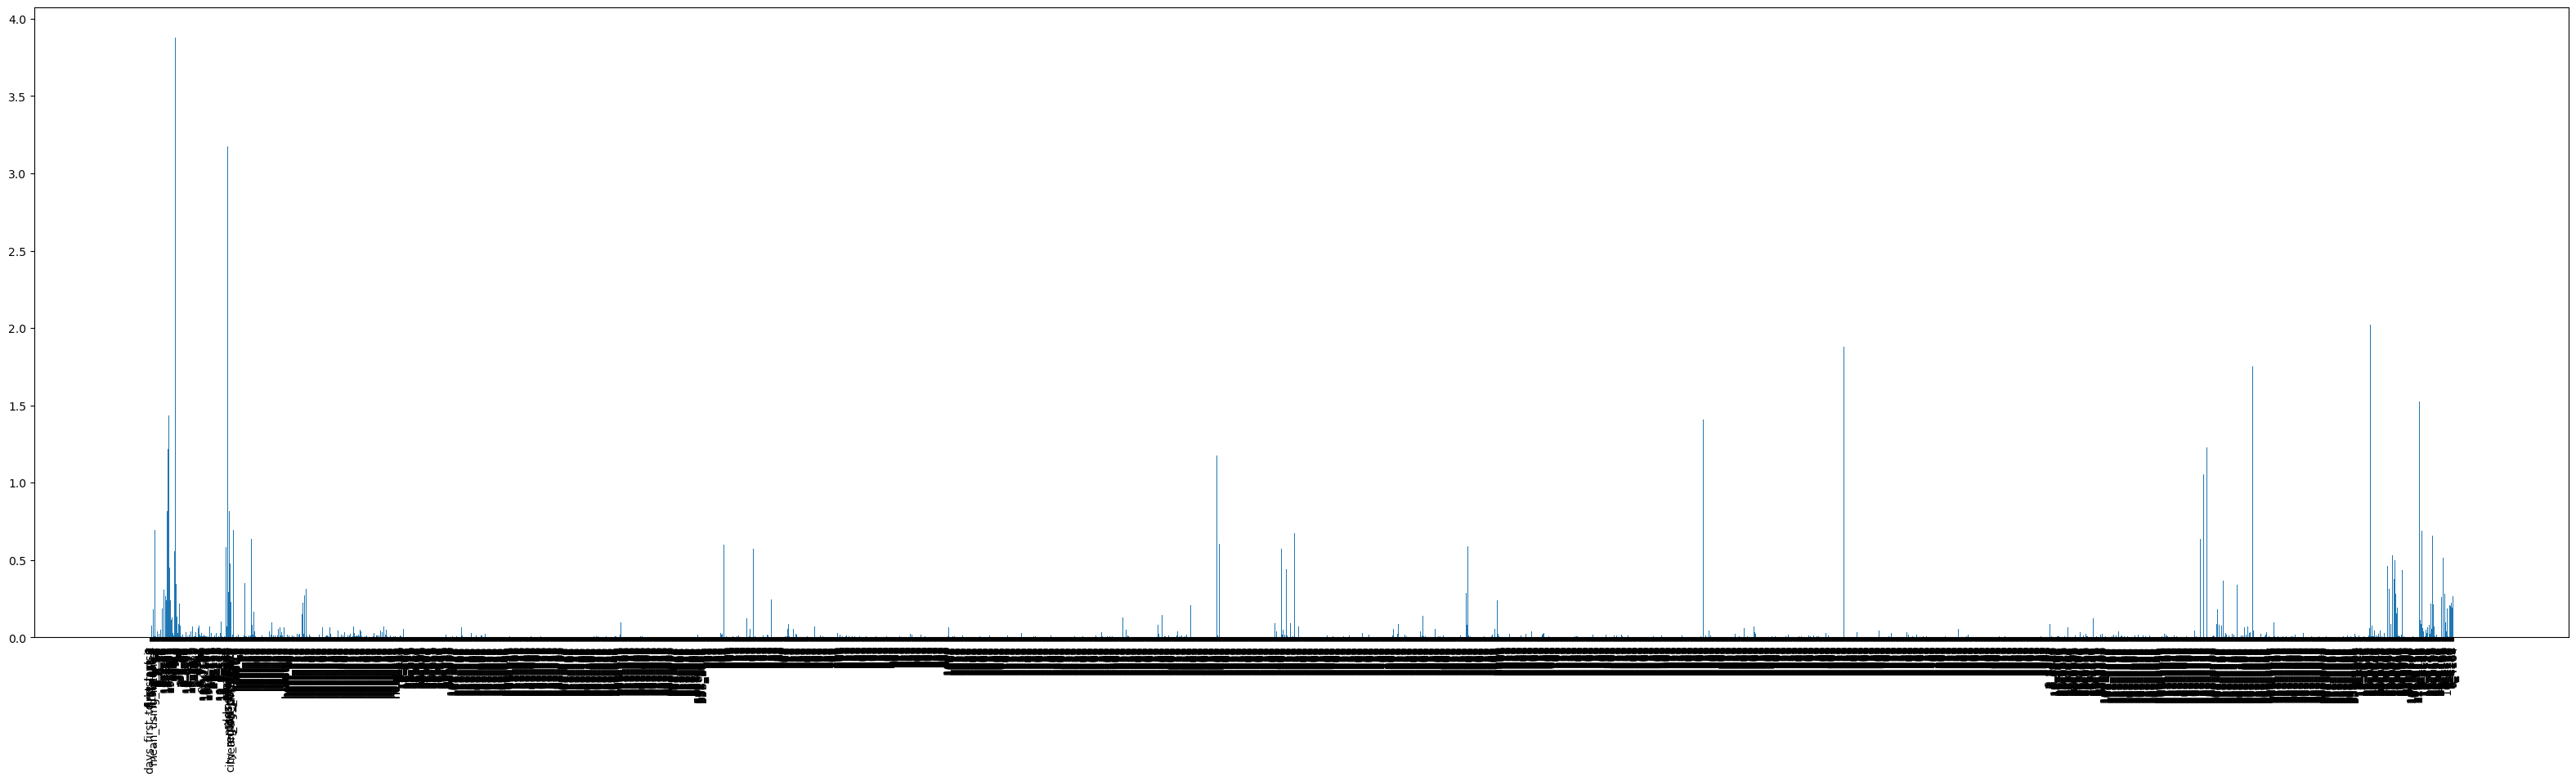

In [25]:
plt.figure(figsize=(40, 10))
plt.bar(train.columns[2:],clf_age.feature_importances_)
plt.xticks(rotation=90);

In [ ]:
import seaborn as sns

In [ ]:
sns.pairplot(train[['is_male','0_4166', 'days_first_to_last_visit']], hue = 'is_male');

In [28]:
print(f'Кол-во беспонтовых фичей: {len(np.where(clf_age.feature_importances_ == 0)[0])}')

Кол-во беспонтовых фичей: 2621
